In [24]:
%load_ext autoreload 
%autoreload 2
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from scipy.sparse import coo_matrix
from scipy.sparse import save_npz

from mimic_helper_fs import get_icd_code_long_title
from mimic_helper_fs import get_ids_with_icd_codes, get_ids_with_kws
from mimic_helper_fs import get_coocurring_symptoms_codes, get_coocurring_symptoms_kws
from mimic_paths import english_names_path, hosp_diagnoses_path, ed_diagnoses_path
from mimic_paths import admissions_path, patients_path, input_events_path

from ipv_codes import SUSPICIOUS_SYMPTOMS_ICD_CODES

np.random.seed(42)
pd.set_option('max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 80)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
english_names = pd.read_csv(english_names_path)
diagnoses = pd.read_csv(hosp_diagnoses_path)
ed_diagnoses = pd.read_csv(ed_diagnoses_path)

In [25]:
input_events = pd.read_csv(input_events_path)

In [43]:
input_events.keys()

Index(['subject_id', 'hadm_id', 'stay_id', 'starttime', 'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate', 'rateuom', 'orderid', 'linkorderid', 'ordercategoryname', 'secondaryordercategoryname', 'ordercomponenttypedescription', 'ordercategorydescription', 'patientweight', 'totalamount', 'totalamountuom', 'isopenbag', 'continueinnextdept', 'cancelreason', 'statusdescription', 'originalamount', 'originalrate'], dtype='object')

In [36]:
weights = input_events.groupby('subject_id')['patientweight'].first()

<AxesSubplot:xlabel='patientweight', ylabel='Count'>

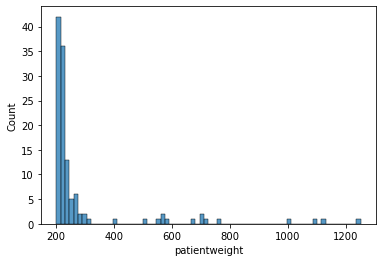

In [41]:
sns.histplot(weights[weights > 200])

In [51]:
from mimic_paths import items_path, chart_events_path
items = pd.read_csv(items_path)
chart_events = pd.read_csv(chart_events_path)


/local/divyas/.conda/envs/ipv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
12809109,10004235,24181354,34100191,2196-02-24 14:39:00,2196-02-28 18:02:00,226707,72,72.0,Inch,0
12809113,10004720,22081550,35009126,2186-11-12 18:02:00,2186-11-13 04:24:00,226707,72,72.0,Inch,0
12809116,10005348,25239799,34629895,2130-10-27 12:06:00,2130-10-27 16:58:00,226707,73,73.0,Inch,0
12809119,10006580,24159665,38329661,2137-08-10 16:23:00,2137-08-10 16:59:00,226707,58,58.0,Inch,0
12809122,10007677,27180483,34992648,2120-11-16 22:36:00,2120-11-17 00:10:00,226707,60,60.0,Inch,0
...,...,...,...,...,...,...,...,...,...,...
300297605,19985885,24999390,34175243,2176-09-04 14:52:00,2176-09-05 07:04:00,226707,60,60.0,Inch,0
300297608,19987238,29437526,32221591,2164-12-17 20:56:00,2164-12-17 21:24:00,226707,68,68.0,Inch,0
300297611,19990427,29695607,34058245,2182-01-14 04:16:00,2182-01-14 10:37:00,226707,65,65.0,Inch,0
300297618,19997448,23560173,33380030,2122-07-23 10:35:00,2122-07-23 11:20:00,226707,63,63.0,Inch,0


In [50]:
items[items['label'].str.contains('Height')]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
1527,226707,Height,Height,chartevents,General,Inch,Numeric,NaN,NaN
1531,226730,Height (cm),Height (cm),chartevents,General,cm,Numeric,NaN,NaN


In [ ]:
chart_events[chart_events['itemid'] == 226707]

# Filter out children

In [3]:
admissions = pd.read_csv(admissions_path)
patients = pd.read_csv(patients_path)

sid_gender_map = dict(zip(patients.subject_id, patients.gender))
sid_age_map = dict(zip(patients.subject_id, patients.anchor_age))
sid_ethnicity_map = dict(zip(admissions.subject_id, admissions.ethnicity))
hadm_id_to_subject_id = dict(zip(diagnoses.hadm_id, diagnoses.subject_id))

diagnoses['anchor_age'] = diagnoses['subject_id'].map(sid_age_map)
diagnoses['ethnicity'] = diagnoses['subject_id'].map(sid_ethnicity_map)


In [4]:
with open('./valid_codes.ob', 'rb') as fp:
    code_list = pickle.load(fp)
print("# of ICD codes that appear > 10 times: ", len(code_list))

# of ICD codes that appear > 10 times:  5544


In [5]:
# We treat each stay as a different patient, since our analysis is not longitudinal.
diagnoses = diagnoses[diagnoses['anchor_age'] > 18]
diagnoses = diagnoses[diagnoses['icd_code'].isin(code_list)]

all_hadm_ids = sorted(list(set(diagnoses['hadm_id'])))
all_icd_codes = sorted(list(set(diagnoses['icd_code'])))
all_subject_ids = [hadm_id_to_subject_id[hadm_id] for hadm_id in all_hadm_ids]

code_to_index = {c: i for i,c in enumerate(all_icd_codes)}
hadm_id_to_index = {hadm_id: i for i, hadm_id in enumerate(all_hadm_ids)}

print("# of Patients: ", len(set(diagnoses['subject_id'])))
print("# of Individual Stays: ", len(set(diagnoses['hadm_id'])))
print("# of Unique ICD Codes: ", len(all_icd_codes))

# of Patients:  192278
# of Individual Stays:  455905
# of Unique ICD Codes:  5544


# Identify symptoms more common in white patients vs. black patients

In [6]:
key='icd_code'
id_type = 'hadm_id'
n_occurrence_threshold = 50
white_patient_ids = set(list(diagnoses[diagnoses['ethnicity'] == 'WHITE'][id_type]))
black_patient_ids = set(list(diagnoses[diagnoses['ethnicity'] == 'BLACK/AFRICAN AMERICAN'][id_type]))

white_patient_d = diagnoses.loc[diagnoses[id_type].map(lambda x:x in white_patient_ids), key]    
white_patient_value_counts = pd.DataFrame(white_patient_d.value_counts())
white_patient_value_counts['proportion_rows_white'] = white_patient_value_counts[key] / len(white_patient_ids)
white_patient_value_counts = white_patient_value_counts[white_patient_value_counts['icd_code'] > n_occurrence_threshold]

black_patient_d = diagnoses.loc[diagnoses[id_type].map(lambda x:x in black_patient_ids), key]
black_patient_value_counts = pd.DataFrame(black_patient_d.value_counts())
black_patient_value_counts['proportion_rows_black'] = black_patient_value_counts[key] / len(black_patient_ids)
black_patient_value_counts = black_patient_value_counts[black_patient_value_counts['icd_code'] > n_occurrence_threshold]

jj = pd.merge(white_patient_value_counts, black_patient_value_counts, left_index=True, right_index=True)
jj['relative_proportion'] = jj['proportion_rows_white']/jj['proportion_rows_black']
# sorted_by_rel_proportion = jj.sort_values('relative_proportion', ascending=False)
sorted_by_rel_proportion = pd.merge(jj, english_names[['icd_code', 'long_title']], 
                                    left_index=True, right_on='icd_code')
sorted_by_rel_proportion = sorted_by_rel_proportion.groupby('icd_code').first().reset_index()
sorted_by_rel_proportion = sorted_by_rel_proportion.sort_values('relative_proportion', ascending=False)
suspicious_symptoms_ICD_codes = list(sorted_by_rel_proportion['icd_code'])
suspicious_symptoms_ICD_codes = suspicious_symptoms_ICD_codes[:10]


In [9]:
len(white_patient_ids), len(black_patient_ids)

(305380, 72979)

## Symptoms most common in white patients

In [7]:
sorted_by_rel_proportion[['icd_code', 'relative_proportion', 'long_title']][:10]

,icd_code,relative_proportion,long_title
1537,V422,5.651119,Heart valve replaced by transplant
1210,K2270,5.465508,Barrett's esophagus without dysplasia
1499,V1051,5.324422,Personal history of malignant neoplasm of bladder
457,53085,4.319394,Barrett's esophagus
66,20410,4.108578,"Chronic lymphoid leukemia, without mention of having achieved remission"
320,41402,3.939277,Coronary atherosclerosis of autologous vein bypass graft
755,8730,3.736324,"Open wound of scalp, without mention of complication"
1560,V4581,3.644409,Aortocoronary bypass status
479,5569,3.610953,"Ulcerative colitis, unspecified"
365,43310,3.546028,Occlusion and stenosis of carotid artery without mention of cerebral infarction


## Symptoms most common in Black patients

In [8]:
sorted_by_rel_proportion[['icd_code', 'relative_proportion', 'long_title']][-10:]

,icd_code,relative_proportion,long_title
567,64663,0.177526,"Infections of genitourinary tract in pregnancy, antepartum condition or comp..."
568,64823,0.168974,"Anemia of mother, antepartum condition or complication"
840,D251,0.164458,Intramural leiomyoma of uterus
70,2181,0.163670,Intramural leiomyoma of uterus
1355,N920,0.158649,Excessive and frequent menstruation with regular cycle
841,D259,0.155629,"Leiomyoma of uterus, unspecified"
69,2180,0.154461,Submucous leiomyoma of uterus
1272,L732,0.134006,Hidradenitis suppurativa
526,58281,0.114202,Chronic glomerulonephritis in diseases classified elsewhere
306,40301,0.076360,"Hypertensive chronic kidney disease, malignant, with chronic kidney disease ..."


# Create one-hot encoded features

In [13]:
one_hot = pd.get_dummies(diagnoses['icd_code'], sparse=True)
hadm_one_hot = pd.concat([diagnoses['hadm_id'], one_hot], axis=1)

In [14]:
diagnoses['icd_code_idx'] = diagnoses['icd_code'].map(code_to_index)
diagnoses['hadm_id_idx'] = diagnoses['hadm_id'].map(hadm_id_to_index)

In [15]:
# Write out one-hot features in coordinate format (helpful since matrix is very sparse)
row_coords = np.array(diagnoses['hadm_id_idx'])
col_coords = np.array(diagnoses['icd_code_idx'])
vals = np.ones(len(col_coords))

n_rows = np.max(row_coords) + 1
n_cols = np.max(col_coords) + 1

# Dummy feature for intercept
intercept_row_coords = np.array(list(range(n_rows)))
intercept_col_coords = [n_cols for i in range(n_rows)]
intercept_vals = np.ones(n_rows)

# Combine features & dummy feature for intercept
row_coords = np.concatenate([row_coords, intercept_row_coords])
col_coords = np.concatenate([col_coords, intercept_col_coords])
vals = np.concatenate([vals, intercept_vals])

# Create sparse matrix
jj = coo_matrix((vals, (row_coords, col_coords)))

In [16]:
# Choose suspicious ICD codes
sus_icd_code_idxs = []
for c in suspicious_symptoms_ICD_codes:
    if c in code_to_index: 
        sus_icd_code_idxs.append(code_to_index[c])

classifier_weights = np.zeros(len(all_icd_codes) + 1)
classifier_weights[sus_icd_code_idxs] = 4
classifier_weights = np.expand_dims(classifier_weights, 1)
classifier_weights[-1] = -3

In [17]:
# Count number of suspicious patients 
kk = jj.dot(classifier_weights)
min_symptoms_val = np.min(kk)
max_symptoms_val = np.max(kk)
r = (kk > min_symptoms_val).astype(int)
print("Range of # of symptoms: ", max_symptoms_val, min_symptoms_val)
print("# Suspicious: ", len(np.where(kk > min_symptoms_val)[0]))
print("# Patients with 0 Suspicious Symptoms: ", len(np.where(kk == min_symptoms_val)[0]))
print("# Patients with 1 Suspicious Symptoms: ", len(np.where(kk == min_symptoms_val +4)[0]))
print("# Patients with 2 Suspicious Symptoms: ", len(np.where(kk == min_symptoms_val +8)[0]))
print("# Patients with 3 Suspicious Symptoms: ", len(np.where(kk == min_symptoms_val +12)[0]))
print("# Patients with 4 Suspicious Symptoms: ", len(np.where(kk == min_symptoms_val +16)[0]))

print("# Total: ", len(kk))

# Transform into p(y) given fixed decision rule
p_y = 1/(1 + np.exp(- kk))
print("Positive probabilities: ", sorted(list(set(np.squeeze(p_y)))))


Range of # of symptoms:  13.0 -3.0
# Suspicious:  26611
# Patients with 0 Suspicious Symptoms:  429294
# Patients with 1 Suspicious Symptoms:  24469
# Patients with 2 Suspicious Symptoms:  2025
# Patients with 3 Suspicious Symptoms:  114
# Patients with 4 Suspicious Symptoms:  3
# Total:  455905
Positive probabilities:  [0.04742587317756678, 0.7310585786300049, 0.9933071490757153, 0.9998766054240137, 0.999997739675702]


In [20]:
test.shape

(455905, 5545)

In [19]:
test = jj.todense()

In [ ]:
# Generate 5 splits of data, regenerating y each time based on p_y
data_dir = "../data/semisynthetic/high_rp/"
n_splits = 5

for split_num in range(n_splits):
    y = (np.random.random(p_y.shape) < p_y).astype(int)
    split_dir = data_dir + str(split_num) + '/'
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)
    
    np.savetxt(split_dir + 'feat_names', all_icd_codes, fmt="%s")
    np.savetxt(split_dir + 'row_names', all_hadm_ids)
    np.savetxt(split_dir + 'subject_ids', all_subject_ids)
    np.savetxt(split_dir + 'suspicious_labels', r)
    np.savetxt(split_dir + 'positive_labels', y)
    np.savetxt(split_dir + 'p_y', p_y)
    np.savetxt(split_dir + 'true_clf_weights', classifier_weights)
    save_npz(split_dir + 'vals.npz', jj)

In [74]:
from scipy.sparse import load_npz

test = load_npz(split_dir + 'vals.npz').todense()

(array([1.60347e+05, 1.27265e+05, 8.61760e+04, 5.22600e+04, 1.80200e+04,
        7.63100e+03, 3.88900e+03, 3.15000e+02, 0.00000e+00, 2.00000e+00]),
 array([ 2. ,  7.3, 12.6, 17.9, 23.2, 28.5, 33.8, 39.1, 44.4, 49.7, 55. ]),
 <BarContainer object of 10 artists>)

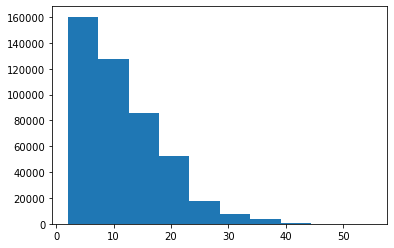

In [81]:
import matplotlib.pyplot as plt
plt.hist(np.sum(test, axis=1))